In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import lightgbm as lgb
import sklearn

from sklearn.ensemble import GradientBoostingRegressor

# load csv

In [2]:
# use 2818.TW as predict target
df2618 = pd.read_csv('04.trade data/trade2618.csv')

# date col
df2618['Date'] = pd.to_datetime(df2618['Date'])
df2618 = df2618.drop(['Date.1'], axis=1)

df2618.head(7)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-04-01,8.547755,8.682064,8.442228,8.672470,11980605,0.0,0
1,2020-04-06,8.662876,8.691657,8.442227,8.653283,20543643,0.0,0
2,2020-04-07,8.787590,8.893119,8.643689,8.701249,18420001,0.0,0
3,2020-04-08,8.701250,9.180922,8.691657,9.132956,32877778,0.0,0
4,2020-04-09,9.248076,10.025145,9.238483,9.929211,65867981,0.0,0
5,2020-04-10,9.785308,9.929211,9.497505,9.833276,25953144,0.0,0
6,2020-04-13,9.689374,9.833275,9.641406,9.737340,14189305,0.0,0


# baseline model
- model 1: from close of the day predict close of tomorow
- model 2: from high of the day predict high of tomorrow
- model 3: from low of the day predict low of tomorrow

In [3]:
df2618['y1'] = df2618['Close'].shift(-1)
df2618['y2'] = df2618['High'].shift(-1)
df2618['y3'] = df2618['Low'].shift(-1)

tr, val = df2618[:-int(len(df2618)*0.10)], df2618[-int(len(df2618)*0.10):]
val = val.drop(val.tail(1).index) # Drop last row
tr.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,y1,y2,y3
0,2020-04-01,8.547755,8.682064,8.442228,8.672470,11980605,0.0,0,8.653283,8.691657,8.442227
1,2020-04-06,8.662876,8.691657,8.442227,8.653283,20543643,0.0,0,8.701249,8.893119,8.643689
2,2020-04-07,8.787590,8.893119,8.643689,8.701249,18420001,0.0,0,9.132956,9.180922,8.691657
3,2020-04-08,8.701250,9.180922,8.691657,9.132956,32877778,0.0,0,9.929211,10.025145,9.238483
4,2020-04-09,9.248076,10.025145,9.238483,9.929211,65867981,0.0,0,9.833276,9.929211,9.497505


In [4]:
def baseline_model_train(train, train_x, train_y, val, val_output):
    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        "seed": 5271,
        "n_estimators": 300,
        'num_leaves': 10,
        'learning_rate': 0.016,
        'verbose': -1
    }
    
    trn_data = lgb.Dataset(train[train_x].values.reshape(-1,1), label = train[train_y])
    ts_data = lgb.Dataset(val[train_x].values.reshape(-1,1), label = val[train_y])

    model = lgb.train(params,
                     train_set=trn_data)
    
    model_pred = model.predict(val[[train_x,train_y]])
    val[val_output] = model_pred

    return val

In [5]:
val = baseline_model_train(tr, 'Close', 'y1', val,'gbr_pred_y1')
val = baseline_model_train(tr, 'High', 'y2', val,'gbr_pred_y2')
val = baseline_model_train(tr, 'Low', 'y3', val,'gbr_pred_y3')
val.head()

c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,y1,y2,y3,gbr_pred_y1,gbr_pred_y2,gbr_pred_y3
529,2022-06-02,33.541921,34.964021,33.394806,34.816906,177272972,0.0,0,34.228451,34.816904,33.934220,34.309348,35.135797,33.707948
530,2022-06-06,34.718830,34.816904,33.934220,34.228451,111592640,0.0,0,33.443844,34.424602,33.394807,34.309348,35.135797,33.707948
531,2022-06-07,34.228453,34.424602,33.394807,33.443844,99254056,0.0,0,33.198654,33.934223,32.953465,33.320233,34.342594,33.707948
532,2022-06-08,33.836148,33.934223,32.953465,33.198654,90488256,0.0,0,33.492882,33.590956,32.561161,33.320233,33.795394,32.957725
533,2022-06-09,32.953462,33.590956,32.561161,33.492882,64226846,0.0,0,32.217896,33.247694,32.217896,33.320233,33.497231,32.957725


In [6]:
# mape for model evaluation
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [7]:
print(f'mape of y1: {mape(val["y1"], val["gbr_pred_y1"])}')
print(f'mape of y2: {mape(val["y2"], val["gbr_pred_y2"])}')
print(f'mape of y3: {mape(val["y3"], val["gbr_pred_y3"])}')

mape of y1: 1.95
mape of y2: 1.79
mape of y3: 1.97


In [8]:
model1_results = val.copy()

# model: using a seq of past obs.
- model1: close as y
- model2: high as y
- model3: low as y

In [9]:
# def function to create features of window
def window_func(window_length, input_x, input_y, df):
    data = df.copy()

    i = 1
    while i < window_length:
        data[f'x_{i}'] = df[input_x].shift(-i)
        i += 1
    
    if i == window_length:
        data[input_y] = df[input_x].shift(-i)
    
    data = data.dropna(axis = 0)

    return data

In [10]:
def ma5_model(train, train_x, train_y, val, val_output):
    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        "seed": 5271,
        "n_estimators": 300,
        'num_leaves': 10,
        'learning_rate': 0.012,
        'verbose': -1
    }
    
    trn_data = lgb.Dataset(train[train_x], label = train[train_y])
    ts_data = lgb.Dataset(val[train_x], label = val[train_y])

    model = lgb.train(params,
                     train_set=trn_data)
    
    model_pred = model.predict(val[train_x+[train_y]])
    val[val_output] = model_pred

    return val

In [11]:
df2618_1 = window_func(5, 'Close', 'y1', df2618)
df2618_1 = window_func(5, 'High', 'y2', df2618_1)
df2618_1 = window_func(5, 'Low', 'y3', df2618_1)

tr, val = df2618_1[:-int(len(df2618_1)*0.10)], df2618_1[-int(len(df2618_1)*0.10):]
tr.head(6)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,y1,y2,y3,x_1,x_2,x_3,x_4
0,2020-04-01,8.547755,8.682064,8.442228,8.672470,11980605,0.0,0,9.833276,9.929211,9.497505,8.442227,8.643689,8.691657,9.238483
1,2020-04-06,8.662876,8.691657,8.442227,8.653283,20543643,0.0,0,9.737340,9.833275,9.641406,8.643689,8.691657,9.238483,9.497505
2,2020-04-07,8.787590,8.893119,8.643689,8.701249,18420001,0.0,0,9.833276,9.929211,9.689375,8.691657,9.238483,9.497505,9.641406
3,2020-04-08,8.701250,9.180922,8.691657,9.132956,32877778,0.0,0,10.217012,10.217012,9.929210,9.238483,9.497505,9.641406,9.689375
4,2020-04-09,9.248076,10.025145,9.238483,9.929211,65867981,0.0,0,9.977177,10.073111,9.881243,9.497505,9.641406,9.689375,9.929210
5,2020-04-10,9.785308,9.929211,9.497505,9.833276,25953144,0.0,0,9.881243,10.169046,9.881243,9.641406,9.689375,9.929210,9.881243


In [12]:
features = ['x_1','x_2','x_3','x_4'] #'Close'
val1 = ma5_model(tr, features, 'y1', val,'gbr_pred_y1')

print(f'mape of y1: {mape(val1["y1"], val1["gbr_pred_y1"])}')

mape of y1: 2.59


c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\Anaconda3\envs\public\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
# gragh of y1 prediction 
# fig = px.line(val1, x = "Date", y = "gbr_pred_y1", title = "model results")
fig = go.Figure()
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["gbr_pred_y1"], mode = "lines", name = "prediction"))
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["y1"], mode = "lines", name = "true price"))
fig.show()

In [14]:
model2_results = val1.drop(['x_1','x_2','x_3','x_4'], axis=1)

In [15]:
# df2618_1 = window_func(5, 'High', 'y2', df2618)

tr, val = df2618_1[:-int(len(df2618_1)*0.10)], df2618_1[-int(len(df2618_1)*0.10):]
val1 = ma5_model(tr, features, 'y2', val,'gbr_pred_y2')
print(f'mape of y2: {mape(val["y2"], val["gbr_pred_y2"])}')

mape of y2: 2.24


c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

c:\Anaconda3\envs\public\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
model2_results = model2_results.merge(val1[['Date', 'gbr_pred_y2']], on='Date', how='left')

In [17]:
# df2618_1 = window_func(5, 'Low', 'y3', df2618)

tr, val = df2618_1[:-int(len(df2618_1)*0.10)], df2618_1[-int(len(df2618_1)*0.10):]
val1 = ma5_model(tr, features, 'y3', val,'gbr_pred_y3')
print(f'mape of y3: {mape(val["y3"], val["gbr_pred_y3"])}')

mape of y3: 2.08


c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

c:\Anaconda3\envs\public\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
model2_results = model2_results.merge(val1[['Date', 'gbr_pred_y3']], on='Date', how='left')

# model: using a seq of past obs. with feature engineering

## feature engineering

In [19]:
df2618_2 = df2618.copy()

def feature_engineering(df):
    # create moving avg
    p = df['Open'].rolling(window = 2).mean()
    df['ma1'] = p.diff()
    df['ma2'] = df['ma1'].diff()
    df['ma3'] = df['ma2'].diff()

    # percent change
    df['high_per'] = (df['High'] - df['Open'])/df['Open']
    df['amplitude'] = (df['High'] - df['Low'])/df['Open']

    # volumn diff percentage for the current day
    df['vol_ma'] = df['Volume'].rolling(window = 5).mean()

    # open diff
    df['open_diff'] = df['Open'].diff()

    # if red K
    df['red_k'] = np.where(df['Close'] > df['Open'], 1, 0)

    # ma5 line we use often
    df['ma5'] = df['Close'].rolling(window = 5).mean()

    return df 

In [20]:
df2618_2 = feature_engineering(df2618_2)
df2618_2['y1'] = df2618_2['Close'].shift(-1)
df2618_2['y2'] = df2618_2['High'].shift(-1)
df2618_2['y3'] = df2618_2['Low'].shift(-1)
df2618_2 = df2618_2.dropna(axis = 0)

tr, val = df2618_2[:-int(len(df2618_2)*0.10)], df2618_2[-int(len(df2618_2)*0.10):]

## training

In [21]:
def lotsoffeature_model(train, train_x, train_y, val, val_output):
    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        "seed": 5271,
        "n_estimators": 300,
        'num_leaves': 10,
        'learning_rate': 0.013,
        'verbose': -1
    }
    
    trn_data = lgb.Dataset(train[train_x], label = train[train_y])
    ts_data = lgb.Dataset(val[train_x], label = val[train_y])

    model = lgb.train(params,
                     train_set=trn_data)
    
    model_pred = model.predict(val[train_x+[train_y]])
    val[val_output] = model_pred

    return val

In [22]:
features = ['Open', 'High', 'Low', 'Close', 'ma1', 'ma2', 'ma3', 'high_per', 'amplitude', 'vol_ma', 'open_diff', 'red_k', 'ma5']
val1 = lotsoffeature_model(tr, features, 'y1', val,'gbr_pred_y1')
print(f'mape of y1: {mape(val["y1"], val["gbr_pred_y1"])}')

mape of y1: 2.19


c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

c:\Anaconda3\envs\public\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
# gragh of y1 prediction 
fig = go.Figure()
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["gbr_pred_y1"], mode = "lines", name = "prediction"))
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["y1"], mode = "lines", name = "true price"))
fig.show()

In [24]:
model3_results = val1.drop(['ma1', 'ma2', 'ma3', 'high_per', 'amplitude', 'vol_ma', 'open_diff', 'red_k', 'ma5'], axis=1).copy()

In [25]:
val1 = lotsoffeature_model(tr, features, 'y2', val,'gbr_pred_y2')
print(f'mape of y2: {mape(val["y2"], val["gbr_pred_y2"])}')

mape of y2: 1.79


c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

c:\Anaconda3\envs\public\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
# gragh of y1 prediction 
fig = go.Figure()
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["gbr_pred_y2"], mode = "lines", name = "prediction"))
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["y2"], mode = "lines", name = "true price"))
fig.show()

In [27]:
model3_results = model3_results.merge(val1[['Date', 'gbr_pred_y2']], on='Date', how='left')

In [28]:
val1 = lotsoffeature_model(tr, features, 'y3', val,'gbr_pred_y3')
print(f'mape of y3: {mape(val["y3"], val["gbr_pred_y3"])}')

mape of y3: 1.76


c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

c:\Anaconda3\envs\public\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
# gragh of y1 prediction 
fig = go.Figure()
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["gbr_pred_y3"], mode = "lines", name = "prediction"))
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["y3"], mode = "lines", name = "true price"))
fig.show()

In [30]:
model3_results = model3_results.merge(val1[['Date', 'gbr_pred_y3']], on='Date', how='left')

# model with prophet

## import packages

In [31]:
import prophet
from prophet import Prophet # should be prophet instead of fbprophet
print('Prophet %s' % prophet.__version__) # check package version, should be 0.5 or higher

Prophet 1.1.1


## predict close

In [32]:
df2618_3 = df2618.copy()
df2618_3 = df2618[['Date', 'Close']]
df2618_3 = df2618_3.rename({'Date': 'ds', 'Close': 'y'}, axis=1) # input col name must be ds, y
tr, val = df2618_3[:-int(len(df2618_3)*0.10)], df2618_3[-int(len(df2618_3)*0.10):]

In [33]:
model = Prophet(daily_seasonality=True)
model.fit(tr)

13:43:51 - cmdstanpy - INFO - Chain [1] start processing
13:43:51 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
pred = val.copy()
future = model.make_future_dataframe(periods=365)
pred = model.predict(future)
# pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

val = val.merge(pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
val.tail()

,ds,y,yhat,yhat_lower,yhat_upper
53,2022-08-17,32.200001,36.486588,35.087143,37.875757
54,2022-08-18,32.299999,36.647554,35.252072,38.227686
55,2022-08-19,31.700001,36.682251,35.225066,38.164865
56,2022-08-22,32.049999,36.747431,35.268272,38.318170
57,2022-08-23,31.799999,36.831446,35.312904,38.212064


In [35]:
print(f'mape of y1: {mape(val["y"], val["yhat"])}')

mape of y1: 14.27


In [36]:
model4_results = model3_results.drop(['gbr_pred_y1', 'gbr_pred_y2', 'gbr_pred_y3'], axis = 1).copy()
val = val.rename({'ds': 'Date', 'yhat': 'gbr_pred_y1'}, axis=1)
model4_results = model4_results.merge(val[['Date', 'gbr_pred_y1']], on='Date', how='left')

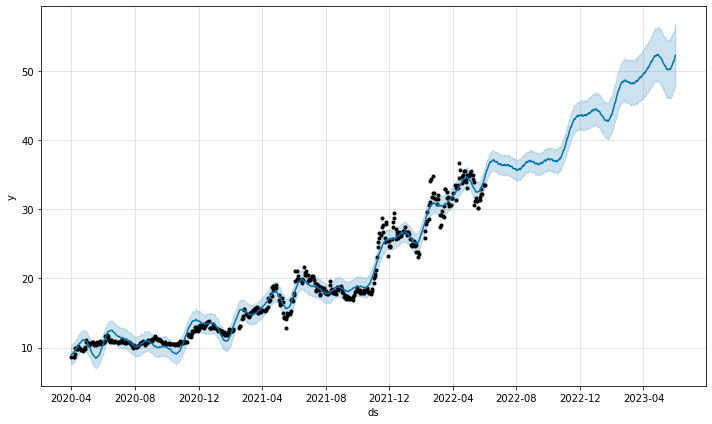

In [37]:
figure1 = model.plot(pred)

## predict high

In [38]:
df2618_3 = df2618.copy()
df2618_3 = df2618[['Date', 'High']]
df2618_3 = df2618_3.rename({'Date': 'ds', 'High': 'y'}, axis=1) # input col name must be ds, y
tr, val = df2618_3[:-int(len(df2618_3)*0.10)], df2618_3[-int(len(df2618_3)*0.10):]

In [39]:
pred = val.copy()
future = model.make_future_dataframe(periods=365)
pred = model.predict(future)

val = val.merge(pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
val.tail()

,ds,y,yhat,yhat_lower,yhat_upper
53,2022-08-17,32.500000,36.486588,35.060169,37.898646
54,2022-08-18,32.299999,36.647554,35.110219,38.190660
55,2022-08-19,32.299999,36.682251,35.227805,38.131438
56,2022-08-22,32.099998,36.747431,35.321914,38.148760
57,2022-08-23,32.150002,36.831446,35.258480,38.334506


In [40]:
print(f'mape of y2: {mape(val["y"], val["yhat"])}')

mape of y2: 12.26


In [41]:
val = val.rename({'ds': 'Date', 'yhat': 'gbr_pred_y2'}, axis=1)
model4_results = model4_results.merge(val[['Date', 'gbr_pred_y2']], on='Date', how='left')

## predict low

In [42]:
df2618_3 = df2618.copy()
df2618_3 = df2618[['Date', 'Low']]
df2618_3 = df2618_3.rename({'Date': 'ds', 'Low': 'y'}, axis=1) # input col name must be ds, y
tr, val = df2618_3[:-int(len(df2618_3)*0.10)], df2618_3[-int(len(df2618_3)*0.10):]

In [43]:
pred = val.copy()
future = model.make_future_dataframe(periods=365)
pred = model.predict(future)

val = val.merge(pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
val.tail()

,ds,y,yhat,yhat_lower,yhat_upper
53,2022-08-17,32.049999,36.486588,35.050383,37.887003
54,2022-08-18,31.799999,36.647554,35.225914,38.088259
55,2022-08-19,31.600000,36.682251,35.306365,38.212916
56,2022-08-22,31.250000,36.747431,35.291817,38.373072
57,2022-08-23,31.700001,36.831446,35.375776,38.290912


In [44]:
print(f'mape of y3: {mape(val["y"], val["yhat"])}')

mape of y3: 16.07


In [45]:
val = val.rename({'ds': 'Date', 'yhat': 'gbr_pred_y3'}, axis=1)
model4_results = model4_results.merge(val[['Date', 'gbr_pred_y3']], on='Date', how='left')

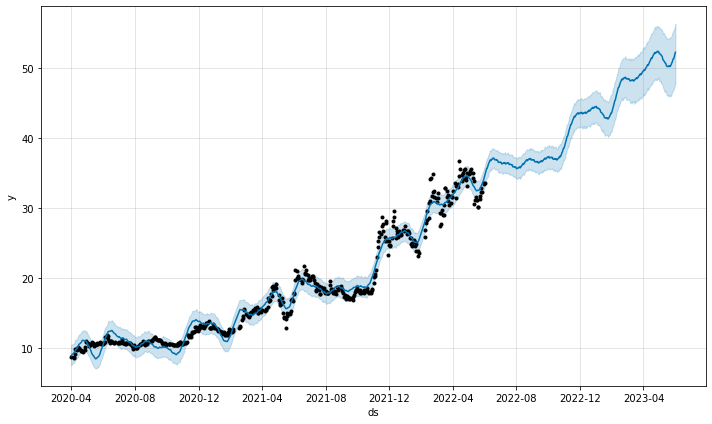

In [46]:
figure3 = model.plot(pred)

# eda of performance of 4 models

In [47]:
del pred, val1, features, df2618_1, df2618_2, df2618_3, future, model

In [48]:
# strategy: buy and sell the next day
# if pred high >= 2% then buy, if y2 >= 2% then sell at 2%, if y3 <= 2%, else sell at close
# if pred low <= 2% then short
def buy_sell_strategy(df):
    df['buy'] = 0
    df['buy_results'] = np.nan
    df['profit_per'] = 0

    for i in range(len(df)):
        if df.loc[i,'gbr_pred_y2'] >= df.loc[i,'Close']*1.02:
            df.loc[i,'buy'] = 1
        else:
            pass
    for i in range(len(df)):
        if df.loc[i,'y2'] >= df.loc[i,'Close']*1.02 and df.loc[i,'y3'] >= df.loc[i,'Close']*0.98:
            df.loc[i,'buy_results'] = df.loc[i,'Close']*1.02
        elif df.loc[i,'y2'] < df.loc[i,'Close']*1.02 and df.loc[i,'y3'] <= df.loc[i,'Close']*0.98:
            df.loc[i,'buy_results'] = df.loc[i,'Close']*0.98
        elif df.loc[i,'y2'] < df.loc[i,'Close']*1.02 and df.loc[i,'y3'] > df.loc[i,'Close']*0.98:
            df.loc[i,'buy_results'] = df.loc[i,'Close']
        else:
            pass 
    for i in range(len(df)):
        if df.loc[i,'buy'] == 1:
            df.loc[i,'profit_per'] = (df.loc[i,'buy_results'] - df.loc[i,'Close'])/df.loc[i,'Close']
        else:
            pass
        
    return df
    

In [50]:
# model1_results = buy_sell_strategy(model1_results)
model2_results = buy_sell_strategy(model2_results)
model3_results = buy_sell_strategy(model3_results)
model4_results = buy_sell_strategy(model4_results)

In [51]:
a = model2_results['profit_per'].sum()
print(f'profit of model 2: {a}')
a = model3_results['profit_per'].sum()
print(f'profit of model 3: {a}')
a = model4_results['profit_per'].sum()
print(f'profit of model 4: {a}')
del a 

profit of model 2: 0.38000000000000006
profit of model 3: -0.1400000000000003
profit of model 4: -0.1400000000000004


In [52]:
model2_results.head(7)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,y1,y2,y3,gbr_pred_y1,gbr_pred_y2,gbr_pred_y3,buy,buy_results,profit_per
0,2022-05-13,31.188101,31.384253,30.305419,31.188101,215961844,0.0,0,30.109268,30.648684,29.913116,30.374064,30.467101,29.596357,0,30.564339,0.00
1,2022-05-16,31.286177,31.923669,30.697721,31.629442,131323188,0.0,0,31.727516,31.874631,30.501571,30.757756,31.426949,30.037643,0,30.996853,0.00
2,2022-05-17,31.580405,31.972706,30.893874,31.188101,128984258,0.0,0,31.335215,32.119820,31.286176,30.936732,31.469919,30.054984,0,31.811863,0.00
3,2022-05-18,31.727516,32.021746,31.139063,31.139063,101705222,0.0,0,32.904427,32.953464,31.678479,31.520565,32.415603,30.964014,1,31.761844,0.02
4,2022-05-19,29.913117,30.354458,28.932359,30.158306,217553520,0.0,0,32.217896,33.296731,32.021747,31.418702,32.379314,30.940823,1,30.761472,0.02
5,2022-05-20,30.354458,30.648684,29.913116,30.109268,104823972,0.0,0,32.266937,33.247695,32.266937,31.673436,33.106159,31.742279,1,30.711454,0.02
6,2022-05-23,30.501571,31.874631,30.501571,31.727516,125036456,0.0,0,33.541920,34.032299,32.953463,32.652707,33.418883,32.555273,1,32.362066,0.02


In [53]:
model3_results.head(7)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,y1,y2,y3,gbr_pred_y1,gbr_pred_y2,gbr_pred_y3,buy,buy_results,profit_per
0,2022-06-01,33.639994,33.885183,33.296730,33.541920,89477545,0.0,0,34.816906,34.964021,33.394806,33.633172,34.050221,32.941090,0,34.212758,0.00
1,2022-06-02,33.541921,34.964021,33.394806,34.816906,177272972,0.0,0,34.228451,34.816904,33.934220,34.177318,34.988210,33.668026,0,34.120568,0.00
2,2022-06-06,34.718830,34.816904,33.934220,34.228451,111592640,0.0,0,33.443844,34.424602,33.394807,34.325043,35.013434,33.682719,1,33.543882,-0.02
3,2022-06-07,34.228453,34.424602,33.394807,33.443844,99254056,0.0,0,33.198654,33.934223,32.953465,33.712296,34.310518,33.035144,1,33.443844,0.00
4,2022-06-08,33.836148,33.934223,32.953465,33.198654,90488256,0.0,0,33.492882,33.590956,32.561161,33.508112,33.839167,32.814763,0,33.198654,0.00
5,2022-06-09,32.953462,33.590956,32.561161,33.492882,64226846,0.0,0,32.217896,33.247694,32.217896,32.915630,34.305325,32.759225,1,32.823024,-0.02
6,2022-06-10,32.904427,33.247694,32.217896,32.217896,126277692,0.0,0,32.021748,32.659238,31.188101,31.883907,32.895133,32.227917,1,31.573538,-0.02


In [54]:
model4_results.head(7)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,y1,y2,y3,gbr_pred_y1,gbr_pred_y2,gbr_pred_y3,buy,buy_results,profit_per
0,2022-06-01,33.639994,33.885183,33.296730,33.541920,89477545,0.0,0,34.816906,34.964021,33.394806,NaN,NaN,NaN,0,34.212758,0.00
1,2022-06-02,33.541921,34.964021,33.394806,34.816906,177272972,0.0,0,34.228451,34.816904,33.934220,34.853193,34.853193,34.853193,0,34.120568,0.00
2,2022-06-06,34.718830,34.816904,33.934220,34.228451,111592640,0.0,0,33.443844,34.424602,33.394807,35.656151,35.656151,35.656151,1,33.543882,-0.02
3,2022-06-07,34.228453,34.424602,33.394807,33.443844,99254056,0.0,0,33.198654,33.934223,32.953465,35.909373,35.909373,35.909373,1,33.443844,0.00
4,2022-06-08,33.836148,33.934223,32.953465,33.198654,90488256,0.0,0,33.492882,33.590956,32.561161,36.136912,36.136912,36.136912,1,33.198654,0.00
5,2022-06-09,32.953462,33.590956,32.561161,33.492882,64226846,0.0,0,32.217896,33.247694,32.217896,36.395465,36.395465,36.395465,1,32.823024,-0.02
6,2022-06-10,32.904427,33.247694,32.217896,32.217896,126277692,0.0,0,32.021748,32.659238,31.188101,36.513515,36.513515,36.513515,1,31.573538,-0.02
